## Assigment 5

In [27]:
import numpy as np
from matplotlib import pyplot as plt
from a5_utils import *
from plotly.offline import init_notebook_mode
import plotly.express as plotly_px
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

## Helper Functions

In [5]:
def readGrayF64(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

## Exercise 1

### A

d = x1 - x2  
x1 = (px / pz) * f  
-x2 = ((T - px) / pz) * f  

d = (px / pz) * f - ((T - px) / pz) * f  
d = (px / pz) * f - (T / pz) * f + (px / pz) * f  
d = 2 * (px / pz) * f - (T / pz) * f  
d = ( 2 * px - T) * f / pz  

The further away the object is (greater pz) the smaller the disparity (smaller d).

### B

In [6]:
def disparity(px, pz, f, T):
    return (2 * px - T) * f / pz

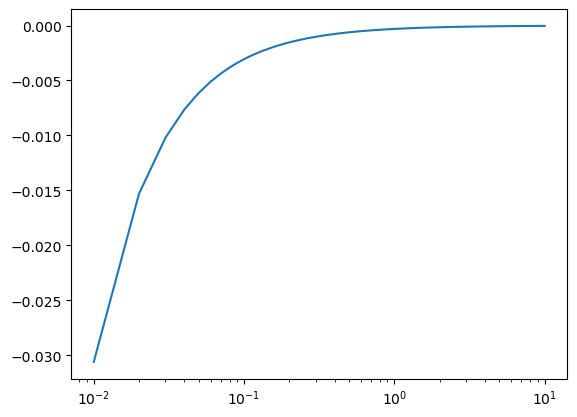

In [7]:
f = 2.55 * 10 ** -3 # 2.55mm
T = 0.12 # 12cm
px = 0

disparity_fnc = lambda pz: disparity(px, pz, f, T)
distances = np.linspace(0.01, 10, 1000)
disparities = list(map(disparity_fnc, distances))

fig, axes = plt.subplots(1, 1)
axes.plot(distances, disparities)
axes.set_xscale('log')

### C

f = 2.5 * 10^(-3) # 2.5 mm  
T = 0.12 # 12 cm  
resolution = 648 x 488 # pixels  
pixel_size = 7.4 * 10^(-6) # 7.4 um, square pixels  

---------------------------------------------  
C1_x = 550 # pixels  
C2_x = 300 # pixels  

C1_m = C1_x * pixel_size # 4.08 mm  
C2_m = C2_x * pixel_size # 2.2 mm  

pz = (px * f) / C1_m  
px = T - (pz * (-C2_m)) / f  

pz = (T - (pz * (-C2_m))) / C1_m  
C1_m * pz = T + pz * C2_m  
pz = T / (C1_m - C2_m)  
  
pz = 0.12 / (0.00408 - 0.0022)  
pz = 63.83 # 63.83 m  

---------------------------------------------  
C2_x = 540 # pixels  
C2_m = C2_x * pixel_size # 4.0 mm  

pz = 0.12 / (0.00408 - 0.004)  
pz = 1500 # 1500 m  

---------------------------------------------  
C1_x = 648 # pixels  
C1_m = C1_x * pixel_size # 4.68 mm  

C2_x = 0 # pixels  
C2_m = C2_x * pixel_size # 0 mm  

pz = 0.12 / (0.00468 - 0)  
pz = 25.53 # 25.53 m  

## Exercise 2

### A

In [8]:
def correspondence_matrix(points1, points2):
    A = np.empty((points1.shape[0], 9))
    for i, (p1, p2) in enumerate(zip(points1, points2)):
        u, v, _ = p1
        u_, v_, _ = p2
        A[i] = [u * u_, u_ * v, u_, u * v_, v * v_, v_, u, v, 1]
    return A

def fundametnal_matrix(points1, points2, normalize=True):
    if normalize:
        points1, T1 = normalize_points(points1)
        points2, T2 = normalize_points(points2)

    A = correspondence_matrix(points1, points2)
    U, D, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    U, D, V = np.linalg.svd(F)
    D[-1] = 0
    F = U @ np.diag(D) @ V

    if normalize:
        F = T2.T @ F @ T1

    # compute epipoles
    U, D, V = np.linalg.svd(F)
    e1 = V[-1] / V[-1, -1]
    U, D, V = np.linalg.svd(F.T)
    e2 = V[-1] / V[-1, -1]

    return F, e1, e2


l = F.T * p' (epipolar line [l] in camera 1 from detected point [p'] in camera 2)  
l' = F * p (epipolar line [l'] in camera 2 from detected point [p] in camera 1)  

In [9]:
F = np.array([[1, 0, 0], [0, 0.5, 0], [0, 0, -1]])
p = np.array([0, 2, 1]).T

l_ = F @ p
print(l_)

p_ = np.array([1, 0, 1]).T
l = F.T @ p_
print(l)

[ 0.  1. -1.]
[ 1.  0. -1.]


### B

In [10]:
house_points = np.loadtxt("./assigments/assigment5/data/epipolar/house_points.txt")
house_points.shape

(10, 4)

In [11]:
points_house_one = house_points[:, :2]
points_house_two = house_points[:, 2:]

In [12]:
F, e1, e2 = fundametnal_matrix(points_house_one, points_house_two)
reference_F = np.loadtxt("./assigments/assigment5/data/epipolar/house_fundamental.txt")
reference_F.shape, F.shape

((3, 3), (3, 3))

In [13]:
e1, e2

(array([1.26868744e+03, 1.46022837e+02, 1.00000000e+00]),
 array([2.00008234e+03, 3.16580226e+02, 1.00000000e+00]))

In [14]:
np.round(F - reference_F, decimals=15)

array([[ 0.e+00, -0.e+00, -0.e+00],
       [ 0.e+00,  0.e+00, -0.e+00],
       [-0.e+00,  0.e+00,  3.e-15]])

In [15]:
house_one = readGrayF64("./assigments/assigment5/data/epipolar/house1.jpg")
house_two = readGrayF64("./assigments/assigment5/data/epipolar/house2.jpg")
house_one.shape, house_two.shape

((288, 384), (288, 384))

In [16]:
def implict(p, q):
    dx = q[0] - p[0]
    dy = q[1] - p[1]
    return np.array([-dy, dx, dy * p[0] - dx * p[1]])

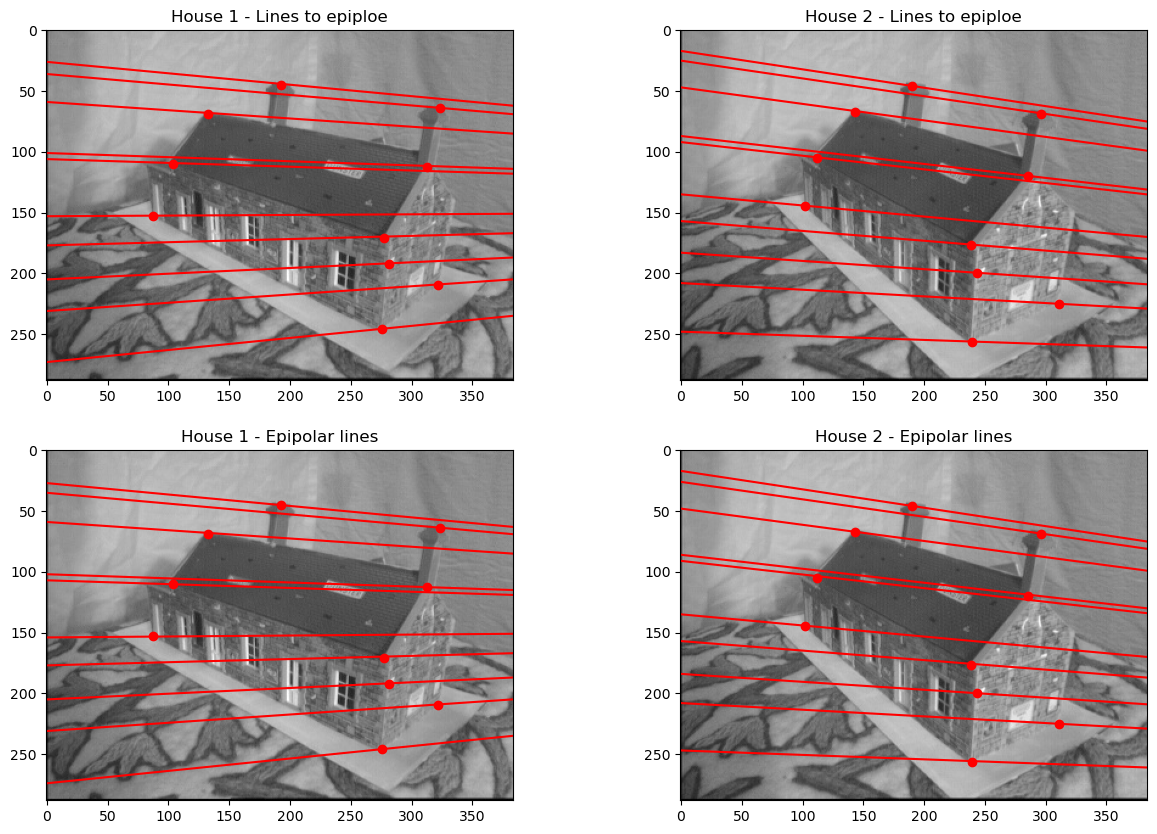

In [17]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.set_title("House 1 - Lines to epiploe")
ax.imshow(house_one, cmap="gray")
for point in points_house_one:
    ax.scatter(point[0], point[1], c="r")
    draw_epiline(implict(e1, point), *house_one.shape)

ax = fig.add_subplot(2, 2, 2)
ax.set_title("House 2 - Lines to epiploe")
ax.imshow(house_two, cmap="gray")
for point in points_house_two:
    ax.scatter(point[0], point[1], c="r")
    draw_epiline(implict(point, e2), *house_two.shape)

ax = fig.add_subplot(2, 2, 3)
ax.set_title("House 1 - Epipolar lines")
ax.imshow(house_one, cmap="gray")
ax.scatter(points_house_one[:, 0], points_house_one[:, 1], c="r")
for point in points_house_two:
    l = F.T @ np.array([point[0], point[1], 1])
    draw_epiline(l, *house_one.shape)

ax = fig.add_subplot(2, 2, 4)
ax.set_title("House 2 - Epipolar lines")
ax.imshow(house_two, cmap="gray")
ax.scatter(points_house_two[:, 0], points_house_two[:, 1], c="r")
for point in points_house_one:
    l = F @ np.array([point[0], point[1], 1])
    draw_epiline(l, *house_two.shape)


### C

In [18]:
def distance_to_epiploar(F, p1, p2):
    l = F.T @ p2
    distance = np.abs(np.dot(l, p1)) / np.sqrt(l[0] ** 2 + l[1] ** 2)
    return distance

def reprojection_error(F, p1, p2):
    p1_to_epipolar = distance_to_epiploar(F, p1, p2)
    p2_to_epipolar = distance_to_epiploar(F.T, p2, p1)
    return (p1_to_epipolar + p2_to_epipolar) / 2

In [19]:
p1 = np.array([85, 233, 1])
p2 = np.array([67, 219, 1])
reprojection_error(F, p1, p2)

0.1467436557046627

In [20]:
average_error = 0
for i in range(points_house_one.shape[0]):
    p1 = np.array([points_house_one[i][0], points_house_one[i][1], 1])
    p2 = np.array([points_house_two[i][0], points_house_two[i][1], 1])
    average_error += reprojection_error(F, p1, p2)
print(average_error / points_house_one.shape[0])

0.3309133698054482


## Exercise 3

### A

In [21]:
def shear_symetric_form(p):
    if p.shape[0] == 2:
        p = [*p, 1]
    return np.array([[0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]])

def triangulate(points1, points2, P1, P2):
    triangulated_points = []
    for i in range(points1.shape[0]):
        ssf_p1 = shear_symetric_form(points1[i])
        ssf_p2 = shear_symetric_form(points2[i])
        A = np.vstack(((ssf_p1 @ P1)[:2, :], (ssf_p2 @ P2)[:2, :]))
        U, D, V = np.linalg.svd(A)
        triangulated_points.append(V[-1][:3] / V[-1, -1])
    return np.array(triangulated_points)

In [22]:
house_one_calibration = np.loadtxt("./assigments/assigment5/data/epipolar/house1_camera.txt")
house_two_calibration = np.loadtxt("./assigments/assigment5/data/epipolar/house2_camera.txt")
house_one_calibration.shape, house_two_calibration.shape

((3, 4), (3, 4))

In [23]:
triangulated_house_points = triangulate(points_house_one, points_house_two, house_one_calibration, house_two_calibration)
triangulated_house_points.shape

(10, 3)

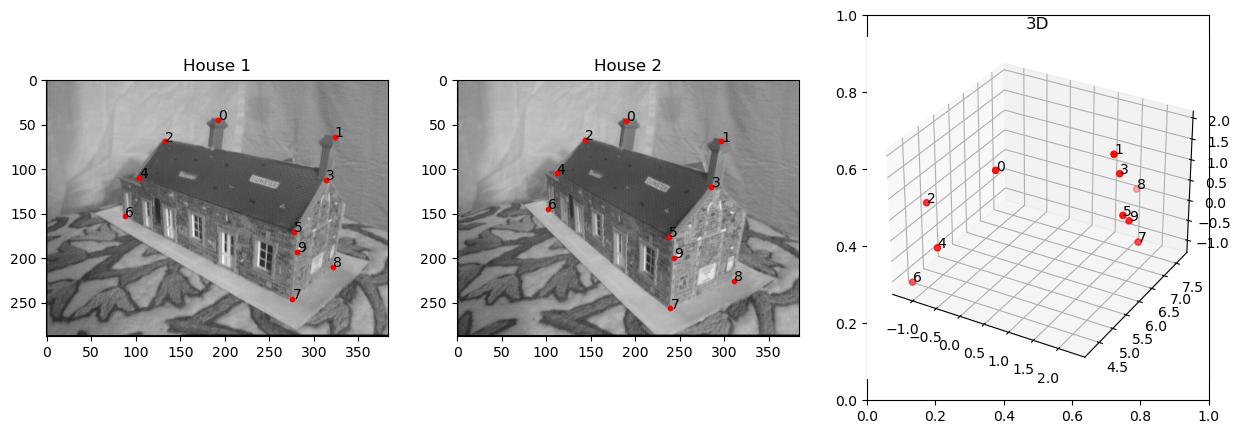

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title("House 1")
axes[0].imshow(house_one, cmap="gray")
axes[0].scatter(points_house_one[:, 0], points_house_one[:, 1], s=10, c="r")
for i in range(points_house_one.shape[0]):
    axes[0].annotate(i, (points_house_one[i][0], points_house_one[i][1]))

axes[1].set_title("House 2")
axes[1].imshow(house_two, cmap="gray")
axes[1].scatter(points_house_two[:, 0], points_house_two[:, 1], s=10, c="r")
for i in range(points_house_two.shape[0]):
    axes[1].annotate(i, (points_house_two[i][0], points_house_two[i][1]))

axes3D = fig.add_subplot(1, 3, 3, projection='3d')
axes3D.set_title("3D")
axes3D.scatter(-triangulated_house_points[:, 0], -triangulated_house_points[:, 2], triangulated_house_points[:, 1], c="r")
for i in range(triangulated_house_points.shape[0]):
    axes3D.text(-triangulated_house_points[i][0], -triangulated_house_points[i][2], triangulated_house_points[i][1], i)


In [46]:
fig = plotly_px.scatter_3d(x=-triangulated_house_points[:, 0], y=-triangulated_house_points[:, 2], z=triangulated_house_points[:, 1], text=range(triangulated_house_points.shape[0]))
fig